# Split data into epochs

In [160]:
%matplotlib inline

import os,re,glob,datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from os.path import join as opj
from tqdm import notebook


def gsearch(*args): return glob.glob(opj(*args))
def str_extract(pattern, s): return re.search(pattern,s).group(0)
def int_extract(pattern, s): return int(str_extract(pattern, s))
def to_date(t, fmt='%Y-%m-%d %H:%M:%S'): return datetime.datetime.fromtimestamp(t).strftime(fmt)

Data files:

In [22]:
map_dir = '../../data/publicMapChangeData/bigserver2.onehouronelife.com/'

# map seed changes
seed_files = gsearch(map_dir, '*time_mapSeed.txt')
seed_files.sort()

# seed change times
seed_times = [int_extract('([0-9]+)(?=time)', f) for f in seed_files]


print(*[to_date(t) for t in seed_times], sep='\n')

2019-11-16 09:14:33
2019-11-18 18:41:43
2019-12-11 04:31:11
2020-01-06 21:22:00
2020-01-06 23:52:27
2020-01-22 17:18:39
2020-01-27 17:08:16
2020-02-18 00:18:59
2020-03-08 04:48:23
2020-03-13 01:04:44
2020-03-29 00:08:31
2020-03-29 20:12:50
2020-03-30 21:24:41
2020-04-17 23:37:36
2020-10-29 18:54:07
2020-12-19 21:01:14


## Check: Are these epochs separate from one another? 

Note: This section violates order (it's dependent on outputs from `2_demographics`). Will move this later.

Get times at which each family started

In [33]:
eve_df = pd.read_csv('../2_demographics/outputs/family_fitness.tsv', sep='\t')
eve_df['eve'] = eve_df['family'].apply(lambda s: int_extract('(?<=eve-)[0-9]+', s))
eve_df['start_t'] = eve_df['family'].apply(lambda s: int_extract('(?<=time-)[0-9]+', s))
eve_df = eve_df[['family', 'eve', 'start_t']]
eve_df = eve_df[eve_df['start_t'] >= seed_times[0]]

print(eve_df.shape)
eve_df.head()

(6046, 3)


,family,eve,start_t
92,time-1573895755_eve-2276905_name-ZABICKI,2276905,1573895755
93,time-1573895904_eve-2276911_name-ROHRER,2276911,1573895904
94,time-1573896101_eve-2276917_name-BADA,2276917,1573896101
95,time-1573896134_eve-2276919_name-SARINA,2276919,1573896134
96,time-1573896495_eve-2276927_name-LISSADE,2276927,1573896495


Select only families that started after the new map log format was introduced
(to-do: in the future, it'd be better to build this in to the data wrangling pipeline)

In [37]:
fam_df = pd.read_csv('../2_demographics/outputs/family_generations.tsv', sep='\t')
fam_df = pd.merge(fam_df, eve_df, on='family')

print(fam_df.shape)
fam_df.head()

(714128, 5)


,family,avatar,gen,eve,start_t
0,time-1609746195_eve-3833245_name-STALLINS,3833245,0,3833245,1609746195
1,time-1609746195_eve-3833245_name-STALLINS,3833283,1,3833245,1609746195
2,time-1609746195_eve-3833245_name-STALLINS,3833278,1,3833245,1609746195
3,time-1609746195_eve-3833245_name-STALLINS,3833274,1,3833245,1609746195
4,time-1609746195_eve-3833245_name-STALLINS,3833391,2,3833245,1609746195


Load all lifelogs

In [40]:
life_df = pd.read_csv('../2_demographics/outputs/all_lifelogs_compact.tsv', sep='\t', index_col = 0)
life_df.head()

/users/nvelezalicea/.conda/envs/py3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,player,avatar,tBirth,parent,birth,tDeath,death,age,cause_of_death,birthX,birthY,deathX,deathY,first,last
0,a12bd25b7ca87b4126ab27e4142ab5136f185e2c,3983348,1613458220,3983322,[-6583 -188],1.613462e+09,[-6592 -192],60.00,oldAge,-6583,-188,-6592.0,-192.0,KANE,S
1,7bd530ec132a3123bbc64f1a7b99a890a78c710f,3983347,1613458114,3983274,[-7544 330],1.613461e+09,[-7548 318],42.14,hunger,-7544,330,-7548.0,318.0,DIA,JAMESON
2,039241fe1322e3c1877753357f239f0e70218553,3983346,1613458026,3983281,[-7552 341],1.613462e+09,[-7548 320],60.00,oldAge,-7552,341,-7548.0,320.0,JANE,JAMESON
3,6b7abc8753b6a431ed0840d88b2c8f103f933639,3983344,1613458002,3983270,[-7695 128],1.613460e+09,[-7677 119],25.22,hunger,-7695,128,-7677.0,119.0,REX,LODEN
4,c0190e141587c8751a311a41df7183a8d1835262,3983343,1613457977,3983276,[-7570 320],1.613462e+09,[-7687 119],60.00,oldAge,-7570,320,-7687.0,119.0,ADELINE,JAMES


Return only lifelogs for members of families that passed the inclusion criteria

In [41]:
fam_life = pd.merge(life_df, fam_df, on='avatar')
print(life_df.shape)
print(fam_life.shape)
fam_life.head()

(2161128, 15)
(714128, 19)


,player,avatar,tBirth,parent,birth,tDeath,death,age,cause_of_death,birthX,birthY,deathX,deathY,first,last,family,gen,eve,start_t
0,a12bd25b7ca87b4126ab27e4142ab5136f185e2c,3983348,1613458220,3983322,[-6583 -188],1.613462e+09,[-6592 -192],60.00,oldAge,-6583,-188,-6592.0,-192.0,KANE,S,time-1613301538_eve-3976182_name-SOUL,96,3976182,1613301538
1,7bd530ec132a3123bbc64f1a7b99a890a78c710f,3983347,1613458114,3983274,[-7544 330],1.613461e+09,[-7548 318],42.14,hunger,-7544,330,-7548.0,318.0,DIA,JAMESON,time-1613444669_eve-3982796_name-JAMESON,8,3982796,1613444669
2,039241fe1322e3c1877753357f239f0e70218553,3983346,1613458026,3983281,[-7552 341],1.613462e+09,[-7548 320],60.00,oldAge,-7552,341,-7548.0,320.0,JANE,JAMESON,time-1613444669_eve-3982796_name-JAMESON,8,3982796,1613444669
3,6b7abc8753b6a431ed0840d88b2c8f103f933639,3983344,1613458002,3983270,[-7695 128],1.613460e+09,[-7677 119],25.22,hunger,-7695,128,-7677.0,119.0,REX,LODEN,time-1613449020_eve-3983028_name-LODEN,6,3983028,1613449020
4,c0190e141587c8751a311a41df7183a8d1835262,3983343,1613457977,3983276,[-7570 320],1.613462e+09,[-7687 119],60.00,oldAge,-7570,320,-7687.0,119.0,ADELINE,JAMES,time-1613444669_eve-3982795_name-JAMES,10,3982795,1613444669


In [42]:
print('First birth: %s' % to_date(np.min(fam_life.tBirth)))
print('Last death: %s' % to_date(np.max(fam_life.tDeath)))

First birth: 2019-11-16 09:15:55
Last death: 2021-02-16 07:50:20


Assign the closest epoch to each family member

In [85]:
def closest_epoch(t):
    closest_tstamp = min([t_s for t_s in seed_times if t_s <= t], key=lambda t_s:abs(t_s-t))
    return to_date(closest_tstamp)

In [86]:
life_epochs = fam_life.copy()
life_epochs = life_epochs[np.isfinite(life_epochs.tDeath)]
life_epochs['eBirth'] = life_epochs['tBirth'].apply(closest_epoch)
life_epochs['eDeath'] = life_epochs['tDeath'].apply(closest_epoch)
life_epochs.head()

,player,avatar,tBirth,parent,birth,tDeath,death,age,cause_of_death,birthX,...,deathX,deathY,first,last,family,gen,eve,start_t,eBirth,eDeath
0,a12bd25b7ca87b4126ab27e4142ab5136f185e2c,3983348,1613458220,3983322,[-6583 -188],1.613462e+09,[-6592 -192],60.00,oldAge,-6583,...,-6592.0,-192.0,KANE,S,time-1613301538_eve-3976182_name-SOUL,96,3976182,1613301538,2020-12-19 21:01:14,2020-12-19 21:01:14
1,7bd530ec132a3123bbc64f1a7b99a890a78c710f,3983347,1613458114,3983274,[-7544 330],1.613461e+09,[-7548 318],42.14,hunger,-7544,...,-7548.0,318.0,DIA,JAMESON,time-1613444669_eve-3982796_name-JAMESON,8,3982796,1613444669,2020-12-19 21:01:14,2020-12-19 21:01:14
2,039241fe1322e3c1877753357f239f0e70218553,3983346,1613458026,3983281,[-7552 341],1.613462e+09,[-7548 320],60.00,oldAge,-7552,...,-7548.0,320.0,JANE,JAMESON,time-1613444669_eve-3982796_name-JAMESON,8,3982796,1613444669,2020-12-19 21:01:14,2020-12-19 21:01:14
3,6b7abc8753b6a431ed0840d88b2c8f103f933639,3983344,1613458002,3983270,[-7695 128],1.613460e+09,[-7677 119],25.22,hunger,-7695,...,-7677.0,119.0,REX,LODEN,time-1613449020_eve-3983028_name-LODEN,6,3983028,1613449020,2020-12-19 21:01:14,2020-12-19 21:01:14
4,c0190e141587c8751a311a41df7183a8d1835262,3983343,1613457977,3983276,[-7570 320],1.613462e+09,[-7687 119],60.00,oldAge,-7570,...,-7687.0,119.0,ADELINE,JAMES,time-1613444669_eve-3982795_name-JAMES,10,3982795,1613444669,2020-12-19 21:01:14,2020-12-19 21:01:14


Does each individual live within the span of a single epoch?

In [87]:
epoch_crossers = life_epochs[life_epochs['eBirth'] != life_epochs['eDeath']]
print(epoch_crossers.shape)
epoch_crossers.head()

(228, 21)


,player,avatar,tBirth,parent,birth,tDeath,death,age,cause_of_death,birthX,...,deathX,deathY,first,last,family,gen,eve,start_t,eBirth,eDeath
524828,55fa8365cde1445df1cd9329c67c469a2a7a1d77,2765652,1583642857,2765606,[-9801 1246],1.583644e+09,[-9806 1197],14.21,hunger,-9801,...,-9806.0,1197.0,WOLF,STAR,time-1583462462_eve-2758941_name-STAR,110,2758941,1583462462,2020-02-18 00:18:59,2020-03-08 04:48:23
524829,45ffd0808fa3060e447c6186463c0577b60f9586,2765649,1583642831,2765597,[-10100 2295],1.583644e+09,[-10098 2341],17.95,hunger,-10100,...,-10098.0,2341.0,TOM,STAR,time-1583462462_eve-2758941_name-STAR,108,2758941,1583462462,2020-02-18 00:18:59,2020-03-08 04:48:23
524830,d324804bb94c557cbb3977e45a7a40e36f8a8a52,2765647,1583642825,2765609,[-10194 1891],1.583644e+09,[-10109 1796],21.07,hunger,-10194,...,-10109.0,1796.0,ILDIKO,OW,time-1583461687_eve-2758861_name-OW,116,2758861,1583461687,2020-02-18 00:18:59,2020-03-08 04:48:23
524831,ebce1c9925ffe021064ea4c2456a8e796e208c55,2765641,1583642593,2765569,[-10204 1886],1.583644e+09,[-10125 1802],23.40,hunger,-10204,...,-10125.0,1802.0,BETH,OW,time-1583461687_eve-2758861_name-OW,116,2758861,1583461687,2020-02-18 00:18:59,2020-03-08 04:48:23
524832,220b040a05df28872599c15187ee7e911d969cc9,2765640,1583642519,2765576,[-10398 2839],1.583643e+09,[-10703 2974],7.74,hunger,-10398,...,-10703.0,2974.0,JOSEPH,OW,time-1583461687_eve-2758861_name-OW,116,2758861,1583461687,2020-02-18 00:18:59,2020-03-08 04:48:23


Are any boundary crossings particularly common?

In [88]:
common_crossings = epoch_crossers.groupby(['eBirth', 'eDeath'])['avatar'].agg('count').reset_index()
common_crossings

,eBirth,eDeath,avatar
0,2019-11-18 18:41:43,2019-12-11 04:31:11,68
1,2019-12-11 04:31:11,2020-01-06 21:22:00,52
2,2020-01-06 23:52:27,2020-01-22 17:18:39,17
3,2020-01-22 17:18:39,2020-01-27 17:08:16,36
4,2020-01-27 17:08:16,2020-02-18 00:18:59,18
5,2020-02-18 00:18:59,2020-03-08 04:48:23,37


Are there regular periods in which families wink in and out?

In [146]:
fam_span = life_epochs.groupby('family').agg({'tBirth': 'min', 'tDeath': 'max'}).reset_index()
fam_span['tDeath'] = fam_span['tDeath'].astype(np.int)

# Time range
first_fam = np.min(fam_span.tBirth)
last_fam = np.max(fam_span.tDeath)

# Liiving families
t_vec = np.linspace(first_fam, last_fam+2, 10000)
living_families = []
for t in notebook.tqdm(t_vec):
    living_families.append(np.sum((fam_span['tBirth'] <= t) & (fam_span['tDeath'] > t)))
    
living_families = np.array(living_families)

In [165]:
date_vec = np.vectorize(lambda t: to_date(t, fmt='%Y-%m-%d'))
extinction_times = t_vec[living_families == 0]
extinction_days = np.unique(date_vec(extinction_times))

extinction_days

array(['2020-01-28', '2020-01-29', '2020-01-30', '2020-02-01',
       '2020-02-02', '2020-02-03', '2020-02-04', '2020-02-19',
       '2020-02-20', '2020-02-21', '2020-02-22', '2020-02-23',
       '2020-02-24', '2020-02-25', '2020-02-26', '2020-02-27',
       '2020-03-05', '2020-03-11', '2020-03-12', '2020-03-13',
       '2020-03-19', '2020-06-27', '2020-07-11', '2020-07-15',
       '2020-07-24', '2020-08-23', '2021-02-07', '2021-02-16'],
      dtype='<U10')

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

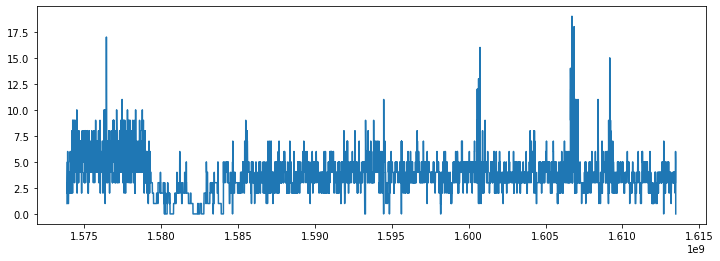

In [166]:
fig = plt.figure(figsize=(12,4))
plt.plot(t_vec, living_families)
plt.axvline(extinction_times, 'r--')

array(['2020-01-28', '2020-01-29', '2020-01-30', '2020-02-01',
       '2020-02-02', '2020-02-03', '2020-02-04', '2020-02-19',
       '2020-02-20', '2020-02-21', '2020-02-22', '2020-02-23',
       '2020-02-24', '2020-02-25', '2020-02-26', '2020-02-27',
       '2020-03-05', '2020-03-11', '2020-03-12', '2020-03-13',
       '2020-03-19', '2020-06-27', '2020-07-11', '2020-07-15',
       '2020-07-24', '2020-08-23', '2021-02-07', '2021-02-16'],
      dtype='<U10')

In [163]:
print(*[to_date(t) for t in seed_times], sep='\n')

2019-11-16 09:14:33
2019-11-18 18:41:43
2019-12-11 04:31:11
2020-01-06 21:22:00
2020-01-06 23:52:27
2020-01-22 17:18:39
2020-01-27 17:08:16
2020-02-18 00:18:59
2020-03-08 04:48:23
2020-03-13 01:04:44
2020-03-29 00:08:31
2020-03-29 20:12:50
2020-03-30 21:24:41
2020-04-17 23:37:36
2020-10-29 18:54:07
2020-12-19 21:01:14
